I start by making a venv and activating it
```
virtualenv venv
.\venv\Scripts\activate
```
Then I install some libraries like pandas and matplotlib.

In [55]:
import pandas as pd
import numpy as np

data_path = "./gorilla_test_data.xlsx"

def read_data(data_path):
    meter_list = pd.read_excel(data_path, sheet_name="meter_list")
    forecast_table = pd.read_excel(data_path, sheet_name="forecast_table")
    rate_table = pd.read_excel(data_path, sheet_name="rate_table")
    # rename the column "date" to "date_period_start" for rate_table. This will make merging easier later on.
    rate_table = rate_table.rename(columns={"date":"date_period_start"})
    return meter_list, forecast_table, rate_table

meter_list, forecast_table, rate_table = read_data(data_path)

## Problem analysis
The usage forecast per day for each meter is in the forecast table. To find the rate for this day, we need the following information:
- the exit zone for that meter in the meter list
- the annual quantity (meter_list.aq_kwh), from which we derive the annual quantity band. 

This information can then be used to find the rate on that day. We can 
- merge the rate for that day on the forecasting table
- multiply it with the usage for that day to calculate the cost
- sum over the meter to determine the total cost.
- do some final transformations to get the result in the desired format

I'll try to maximize the efficiency, to make sure we can use this code for large datasets. In practice, the efficiency gain is not always worth the reduced readability. However, for this exercise I'll assume that we need to process an enormous dataset, and that efficiency is more important than readability.

# Part 1: vectorized solution.


To start, I'll determine the quantity band for each meter in meter_list. We can identify a band by its aq_min_kwh.
There are 3 bands:
- 0-73200 kwh
- 73200 - 732000 kwh
- \> 732000 kwh



In [56]:
meter_list.head(1)

,meter_id,aq_kwh,exit_zone
0,14676236,28978,EA1


In [57]:
def add_aq_min_kwh(meter_list):
    is_more_than = [meter_list["aq_kwh"] >= 732000,
                    meter_list["aq_kwh"] >= 73200]
    choices = [732000,73200]
    meter_list["aq_min_kwh"] = np.select(is_more_than, choices, default=0)
    return meter_list

meter_list = add_aq_min_kwh(meter_list)
meter_list

,meter_id,aq_kwh,exit_zone,aq_min_kwh
0,14676236,28978,EA1,0
1,34509937,78324,SO1,73200
2,50264822,265667,NT1,73200
3,88357331,484399,SE2,73200


Now let's merge this info on the forecast table. We don't need the aq_kwh anymore.

In [58]:
def merge_meter_list_forecast_table(meter_list, forecast_table):
    forecast_table = forecast_table.merge(meter_list[["meter_id", "exit_zone", "aq_min_kwh"] ], on="meter_id")
    return forecast_table

forecast_table = merge_meter_list_forecast_table(meter_list, forecast_table)

In [59]:
forecast_table.head(1)

,meter_id,date,kwh,exit_zone,aq_min_kwh
0,14676236,2020-06-01,22.070768,EA1,0


Now we can add the rate for each day based on the aq_min_kwh and the exit zone. However, we can't just merge since the rate_table only has the start of the period,not every date. 

Here is a simple solution: for every day in the forecast table, we add the date of the start of that period. Then we can simply merge on exit zone, aq_min_kwh and date.

In [61]:
# Find uniques.
set(rate_table["date_period_start"].values)

{numpy.datetime64('2020-04-01T00:00:00.000000000'),
 numpy.datetime64('2020-10-01T00:00:00.000000000'),
 numpy.datetime64('2021-04-01T00:00:00.000000000'),
 numpy.datetime64('2021-10-01T00:00:00.000000000'),
 numpy.datetime64('2022-04-01T00:00:00.000000000'),
 numpy.datetime64('2022-10-01T00:00:00.000000000'),
 numpy.datetime64('2023-04-01T00:00:00.000000000'),
 numpy.datetime64('2023-10-01T00:00:00.000000000'),
 numpy.datetime64('2024-04-01T00:00:00.000000000'),
 numpy.datetime64('2024-10-01T00:00:00.000000000')}

By inspecting the dataset we find that the rate table has a simple structure. For every meter, for every aq band, we have a winter and a summer rate for every year. We can use this to efficiently determine the period for the dates in the forecast table.

In [48]:
def add_period_start_date(forecast_table):
    # three cases
    # winter, beginning of the year. In that case, the period start is october first of the previous year.
    is_before_april = forecast_table["date"].dt.month < 4
    # in the summer, the period start is april first of the current year.
    is_summer = (forecast_table["date"].dt.month >= 4) & (forecast_table["date"].dt.month < 10)
    # for the end of the year, the period start is october first of the current year.
    is_after_october = forecast_table["date"].dt.month >= 10

    # Overwrite the date_period_start column with the correct date. 
    forecast_table["date_period_start"] = forecast_table["date"] 
    
    period_start_before_april = pd.to_datetime(forecast_table["date"].dt.year - 1, format="%Y")  + pd.offsets.MonthBegin(9)
    forecast_table["date_period_start"] = np.where(is_before_april, period_start_before_april , forecast_table["date_period_start"])

    period_start_summer = pd.to_datetime(forecast_table["date"].dt.year, format="%Y") + pd.offsets.MonthBegin(3)
    forecast_table["date_period_start"] = np.where(is_summer, period_start_summer, forecast_table["date_period_start"])

    period_start_after_october = pd.to_datetime(forecast_table["date"].dt.year, format="%Y") + pd.offsets.MonthBegin(9)
    forecast_table["date_period_start"] = np.where(is_after_october, period_start_after_october, forecast_table["date_period_start"])
    return forecast_table

In [62]:
forecast_table = add_period_start_date(forecast_table)
forecast_table.head(2)

,meter_id,date,kwh,exit_zone,aq_min_kwh,date_period_start
0,14676236,2020-06-01,22.070768,EA1,0,2020-04-01
1,14676236,2020-06-02,19.170720,EA1,0,2020-04-01


This works. Now we can join the rate on the days, and calculate the cost per day.

In [63]:
forecast_table_with_rate = forecast_table.merge(rate_table, on=["date_period_start", "exit_zone", "aq_min_kwh"])

In [65]:
forecast_table_with_rate["cost"] = forecast_table_with_rate["kwh"] * forecast_table_with_rate["rate_p_per_kwh"]
forecast_table_with_rate.head()

,meter_id,date,kwh,exit_zone,aq_min_kwh,date_period_start,aq_max_kwh,rate_p_per_kwh,cost
0,14676236,2020-06-01,22.070768,EA1,0,2020-04-01,73200.0,0.2652,5.853168
1,14676236,2020-06-02,19.170720,EA1,0,2020-04-01,73200.0,0.2652,5.084075
2,14676236,2020-06-03,23.555111,EA1,0,2020-04-01,73200.0,0.2652,6.246815
3,14676236,2020-06-04,18.220712,EA1,0,2020-04-01,73200.0,0.2652,4.832133
4,14676236,2020-06-05,14.196134,EA1,0,2020-04-01,73200.0,0.2652,3.764815


In [73]:
# Sum per meter_id
result_table = forecast_table_with_rate.groupby("meter_id")[[ "kwh", "cost"]].sum().reset_index()
result_table["cost"] = (result_table["cost"]/100).round(2)
# set column names to: Meter ID | Total Estimated Consumption (kWh) | Total Cost (£)
result_table.columns = ["Meter ID", "Total Estimated Consumption (kWh)", "Total Cost (£)"]
result_table

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


### Now we can put it all together.

In [92]:
def calculate_total_cost(meter_list, forecast_table, rate_table):
    meter_list = add_aq_min_kwh(meter_list)
    forecast_table = merge_meter_list_forecast_table(meter_list, forecast_table)
    forecast_table = add_period_start_date(forecast_table)
    forecast_table_with_rate = forecast_table.merge(rate_table, on=["date_period_start", "exit_zone", "aq_min_kwh"])
    forecast_table_with_rate["cost"] = forecast_table_with_rate["kwh"] * forecast_table_with_rate["rate_p_per_kwh"]
    result_table = forecast_table_with_rate.groupby("meter_id")[[ "kwh", "cost"]].sum().reset_index()
    result_table["cost"] = (result_table["cost"]/100).round(2)
    result_table.columns = ["Meter ID", "Total Estimated Consumption (kWh)", "Total Cost (£)"]
    return result_table

In [93]:
meter_list, forecast_table, rate_table = read_data(data_path)
result_table = calculate_total_cost(meter_list, forecast_table, rate_table)

In [94]:
result_table

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


By using vectorized computations, we efficiently computed the total cost per meter.

Now let's see if we can make things more efficient: 
- Instead of merging everything and summing at the end, we sum first and the merge as necessary. 
- Then we verify that this approach is faster by creating some artificial datasets.

# Part 2 
Optimization.

The beginning remains the same. We add the aq bands to the meter list.

But then, we add the date_period_start on forecast table so that we can sum the the forecast by meter_id and period.
Only then do we merge the exit zone and the rate table. The table should be smaller then, so the amount of merge computation (and multiplication) should be less. I guesstimate that this could reduce the compute time by more than 50%. 

### New algo:
- add_aq_min_kwh
- add_period_start_date to forecast
- sum over meter_id and date_period_start
- merge meter_list exit zone onto forecast table
- merge rate_table on date_period_start, exit_zone and aq_min_kwh
- calculate total cost   

In [96]:
meter_list, forecast_table, rate_table = read_data(data_path) # get some fresh data

def calculate_total_cost_optimized(meter_list, forecast_table, rate_table):
    meter_list = add_aq_min_kwh(meter_list)
    # forecast_table = merge_meter_list_forecast_table(meter_list, forecast_table)
    forecast_table = add_period_start_date(forecast_table)
    forecast_table_summed = forecast_table.groupby(["meter_id", "date_period_start"])[["kwh"]].sum().reset_index()
    forecast_table_summed = forecast_table_summed.merge(meter_list[["meter_id", "exit_zone", "aq_min_kwh"] ], on="meter_id")
    forecast_table_summed = forecast_table_summed.merge(rate_table, on=["date_period_start", "exit_zone", "aq_min_kwh"])
    forecast_table_summed["cost"] = forecast_table_summed["kwh"] * forecast_table_summed["rate_p_per_kwh"]

    result_table = forecast_table_summed.groupby("meter_id")[[ "kwh", "cost"]].sum().reset_index()
    result_table["cost"] = (result_table["cost"]/100).round(2)
    result_table.columns = ["Meter ID", "Total Estimated Consumption (kWh)", "Total Cost (£)"]

    return result_table

In [97]:
result_table = calculate_total_cost_optimized(meter_list, forecast_table, rate_table)
result_table

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


Both results are the same, which is a good sign.

# Part 3: evaluation on synthethic dataset.

First let's write some code to make a synthetic dataset. Although not requested, meter_list.aq_kwh is the correct sum of the generated days. 

In [161]:
def generate_random_meters(n_meters, rate_table):
    all_exit_zones = rate_table["exit_zone"].unique()
    meter_ids = list(range(n_meters))
    aq_kwhs = np.random.rand(n_meters) * 100000  # Random annual quantity between 0 and 100000
    exit_zones = np.random.choice(all_exit_zones, size=n_meters)
    meter_list = pd.DataFrame({"meter_id": meter_ids, "aq_kwh": aq_kwhs, "exit_zone": exit_zones})
    
    return meter_list

def generate_mock_consumption(meter_list, start_date, duration):
    date_array = np.arange(start_date, np.datetime64(start_date) + np.timedelta64(duration, 'D'), dtype="datetime64[D]")
    forecasted_tables = []
    total_kwhs = []
    for meter_id in meter_list["meter_id"]:
        forecasted_kwh = np.random.rand(len(date_array)) * 20  # Random daily consumption up to 20 kWh
        total_kwhs.append(forecasted_kwh.sum())
        meter_id_column = np.full(len(date_array), meter_id)
        df = pd.DataFrame({"meter_id": meter_id_column, "date": date_array, "kwh": forecasted_kwh})
        forecasted_tables.append(df)
    meter_list["aq_kwh"] = total_kwhs # fix the total consumption
    total_forecast_table = pd.concat(forecasted_tables).reset_index(drop=True)

    return total_forecast_table, meter_list

def generate_synthetic_data(n_meters, rate_table, start_date, duration):
    meter_list = generate_random_meters(n_meters, rate_table)
    forecast_table, meter_list = generate_mock_consumption(meter_list, start_date, duration)

    return meter_list, forecast_table


In [155]:
meter_list, total_forecast_table = generate_synthetic_data(50000, rate_table, "2022-01-01", 730)
meter_list.head(1)

,meter_id,aq_kwh,exit_zone
0,0,6925.950499,SW1


In [160]:
# Verify that the code is correct. This should be the same as the aq_kwh above.
total_forecast_table[total_forecast_table["meter_id"]==0]["kwh"].sum()

6925.950498842906

The comparison code below was generated by ChatGPT to save some time.

Optimized function is 13.24% times faster than the standard function for n = 10
Optimized function is 29.54% times faster than the standard function for n = 100
Optimized function is 34.98% times faster than the standard function for n = 1000
Optimized function is 35.34% times faster than the standard function for n = 10000
Optimized function is 33.87% times faster than the standard function for n = 100000


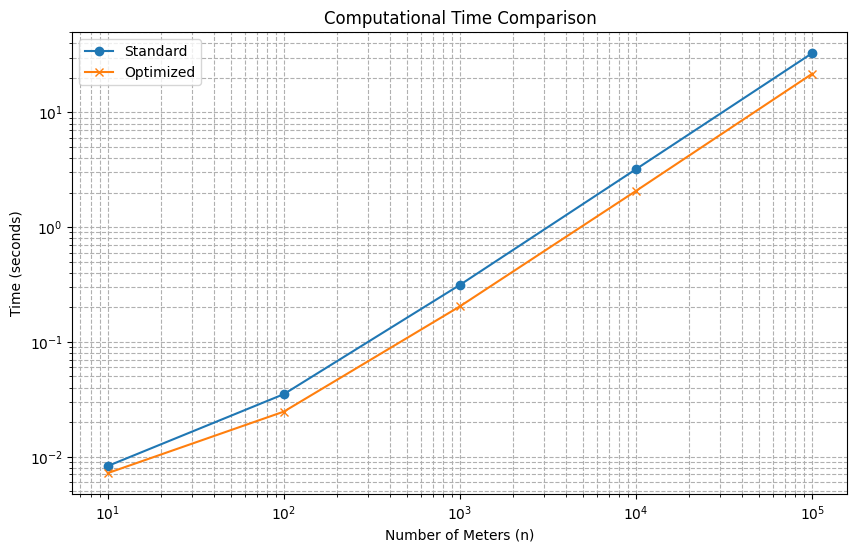

In [163]:
import matplotlib.pyplot as plt
import timeit

# Assuming rate_table is already defined in the scope
# and the functions calculate_total_cost, calculate_total_cost_optimized, and generate_synthetic_data are defined

n_values = [10, 100, 1000, 10000, 100000]  # Different n values for which to generate data and test
times_standard = []
times_optimized = []

for n in n_values:
    meter_list, forecast_table = generate_synthetic_data(n, rate_table, "2022-01-01", 730) # 2 years
    
    # Time the standard function using timeit
    time_standard = timeit.timeit(lambda: calculate_total_cost(meter_list, forecast_table, rate_table), number=1)
    times_standard.append(time_standard)
    
    # Time the optimized function using timeit
    time_optimized = timeit.timeit(lambda: calculate_total_cost_optimized(meter_list, forecast_table, rate_table), number=1)
    times_optimized.append(time_optimized)
    print(f"Optimized function is {round((1- time_optimized / time_standard)*100, 2)}% times faster than the standard function for n = {n}")

# Plotting the results on a log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_values, times_standard, label='Standard', marker='o')
plt.loglog(n_values, times_optimized, label='Optimized', marker='x')
plt.xlabel('Number of Meters (n)')
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [267]:
print(f"We process {n_values[-1]} meters, with a total of {len(forecast_table)} forecast rows in {round(times_optimized[-1], 2)} seconds.")

We process 100000 meters, with a total of 7300000 forecast rows in 23.45 seconds.


# Conclusion & observation.

By relying on numpy's vectorized operations, this computation can be done very efficiently. I made an optimization to the algorithm that signficantly reduces the amount of rows to merge and multiply. Although my estimation of a 50% time reduction turned out to be overly optimistic, the optimized function is ~34% faster. Since the optimization reduces the amount of merge and multiplications by 180x (only 2 per year instead of 365), and we see only marginal benefits, we can derive that the most computationally expensive operation is the date processing. We can do performance profiling to verify this.


The plot also shows that the code scales linearly with the amount of rows.

Then there are a couple of ways to further improve performance:
- we can look at the most expensive computations and see if there's anything more we can optimize.
- we could use multiprocessing to distribute the load over multiple cores.

However, this simple algorithm can already process a large amount of data in acceptable time. In practice, we'd have to consider development cost, code readability, and dataset size before we optimize further. 


At this points I'm 3:30h into the exercise, and I consider the above solution satisfactory. But I'm curious if my conclusion that the date computation is the most expensive, is correct. Let's find out!

# Bonus: Profiling

In [169]:
%load_ext snakeviz
meter_list, total_forecast_table = generate_synthetic_data(10000, rate_table, "2022-01-01", 730)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [172]:
def main():
    calculate_total_cost_optimized(meter_list, total_forecast_table, rate_table)

# Using snakeviz for an interactive visualization of the profile
# %snakeviz main()


 
*** Profile stats marshalled to file 'C:\\Users\\timen\\AppData\\Local\\Temp\\tmpw0oll1ec'.
Embedding SnakeViz in this document...
<function display at 0x0000027DEC7F0540>


In [174]:
# Vs code has trouble displaying this, but we can open the results in the browser and copy the results to a markdown cell.

# !snakeviz C:\\Users\\timen\\AppData\\Local\\Temp\\tmpw0oll1ec

^C


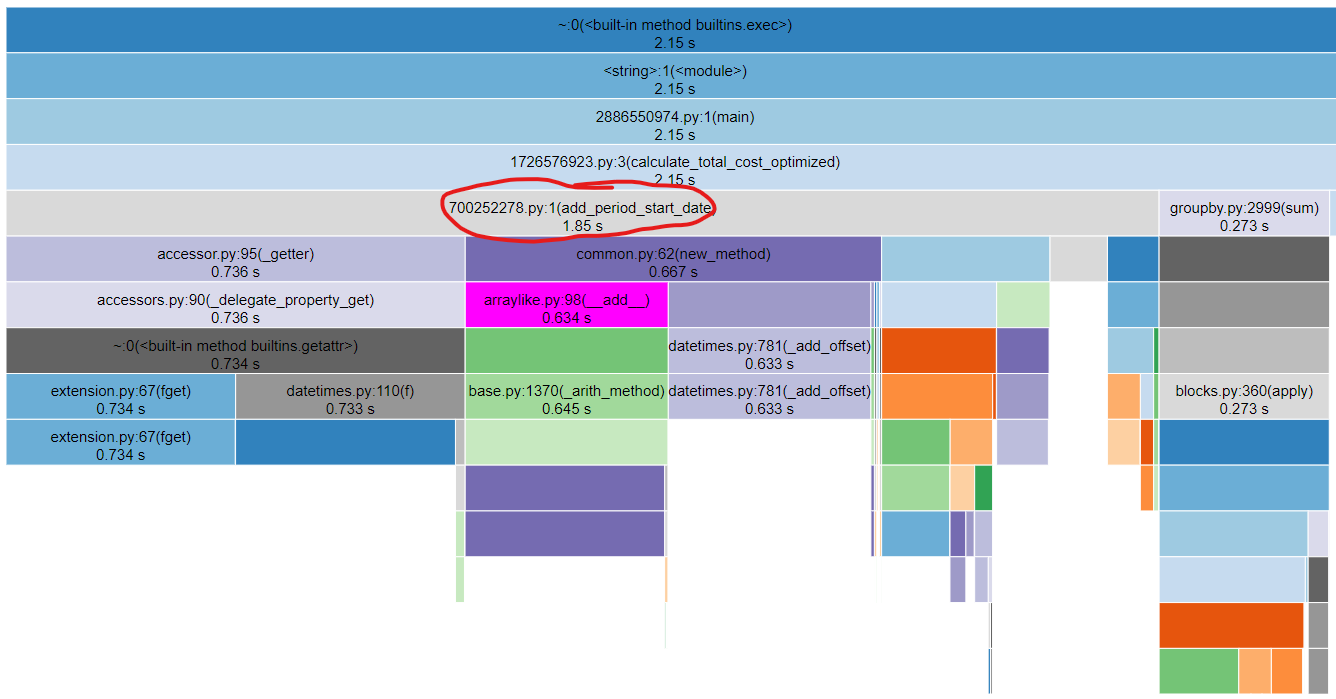

The results confirm the hypothesis: the add_period_start_date takes up 86% of the time. Consequently, this would be the first target for optimization. 

One remark is that the dates are repeated for every meter. So in theory we could calculate the date => date_period_start mapping once, and then apply it to every meter. 

If we assume that all meters have the same list of dates, we can do this very efficiently. This assumption holds for the synthetic data and given that the dataset is a forecast, it is likely that we'll have these values in practice too.

In [247]:
# The optimized version only calculates the date => date_period_start for one meter_id, and then uses it for all meter_ids.
# This assumes that all meter_ids have the same dates.
def add_period_start_date_optimized(forecast_table, start_date, duration, n_meters):
    date_array = np.arange(start_date, np.datetime64(start_date) + np.timedelta64(duration, 'D'), dtype="datetime64[D]")
    pd_date_array = pd.to_datetime(date_array, format = "%Y-%m-%d")

    is_before_april = pd_date_array.month < 4
    is_summer = (pd_date_array.month >= 4) & (pd_date_array.month < 10)
    is_after_october = pd_date_array.month >= 10

    period_start_before_april = pd.to_datetime(pd_date_array.year - 1, format="%Y")  + pd.offsets.MonthBegin(9)
    period_start_summer = pd.to_datetime(pd_date_array.year, format="%Y") + pd.offsets.MonthBegin(3)
    period_start_after_october = pd.to_datetime(pd_date_array.year, format="%Y") + pd.offsets.MonthBegin(9)

    pd_date_array = np.where(is_before_april, period_start_before_april , pd_date_array)
    pd_date_array = np.where(is_summer, period_start_summer, pd_date_array)
    pd_date_array = np.where(is_after_october, period_start_after_october, pd_date_array)
    total_date_array = np.concatenate([pd_date_array]*n_meters)

    forecast_table["date_period_start"] = total_date_array
    return forecast_table

# Let's compare the optimized function to the original one

In [229]:
start_date = "2022-01-01"
duration = 730
n_meters = 100000

meter, forecast_table = generate_synthetic_data(n_meters, rate_table, start_date, duration)

In [230]:
%timeit forecast_table_1 = add_period_start_date(forecast_table)

18.2 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [231]:
meter, forecast_table = generate_synthetic_data(n_meters, rate_table, start_date, duration)

In [232]:
%timeit forecast_table_2 = add_period_start_date_optimized(forecast_table, start_date, duration, n_meters)


389 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected, the optimized function is much faster. Now we can plug it in the the rest of the solution.

In [255]:
def calculate_total_cost_optimized_date(meter_list, forecast_table, rate_table):
    n_meters = len(meter_list)
    
    meter_list = add_aq_min_kwh(meter_list)
    start_date = forecast_table["date"].min()
    duration = (forecast_table["date"].max() - pd.to_datetime(start_date)).days + 1
    forecast_table = add_period_start_date_optimized(forecast_table, start_date, duration, n_meters)
    forecast_table_summed = forecast_table.groupby(["meter_id", "date_period_start"])[["kwh"]].sum().reset_index()
    forecast_table_summed = forecast_table_summed.merge(meter_list[["meter_id", "exit_zone", "aq_min_kwh"] ], on="meter_id")
    forecast_table_summed = forecast_table_summed.merge(rate_table, on=["date_period_start", "exit_zone", "aq_min_kwh"])
    forecast_table_summed["cost"] = forecast_table_summed["kwh"] * forecast_table_summed["rate_p_per_kwh"]

    result_table = forecast_table_summed.groupby("meter_id")[[ "kwh", "cost"]].sum().reset_index()
    result_table["cost"] = (result_table["cost"]/100).round(2)
    result_table.columns = ["Meter ID", "Total Estimated Consumption (kWh)", "Total Cost (£)"]

    return result_table

We add the new optimized function to the plot:

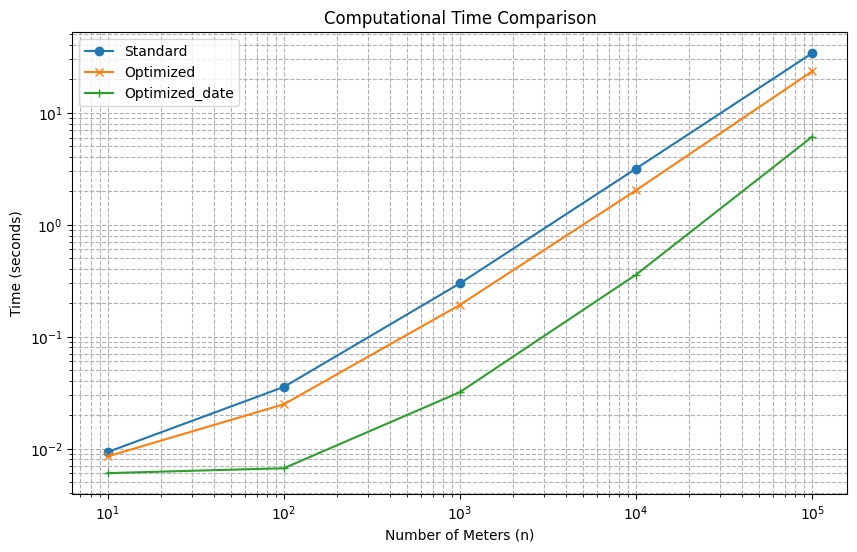

The first optimization is 45.3% faster than the first optimized function for n = 100000 
The second optimization is 283.97% faster than the first optimized function for n = 100000 and 457.89% faster than the standard function for n = 100000
We handle 100000 meters, with a total of 73000000 forecast rows in 6.11 seconds.


In [258]:
import matplotlib.pyplot as plt
import timeit

n_values = [10, 100, 1000, 10000, 100000]  # Different n values for which to generate data and test
times_standard = []
times_optimized = []
times_optimized_2 = []
for n in n_values:
    meter_list, forecast_table = generate_synthetic_data(n, rate_table, "2022-01-01", 730) # 2 years
    
    # Time the standard function using timeit
    time_standard = timeit.timeit(lambda: calculate_total_cost(meter_list, forecast_table, rate_table), number=1)
    times_standard.append(time_standard)
    
    # Time the optimized function using timeit
    time_optimized = timeit.timeit(lambda: calculate_total_cost_optimized(meter_list, forecast_table, rate_table), number=1)
    times_optimized.append(time_optimized)

    # Time the optimized function using timeit
    time_optimized_2 = timeit.timeit(lambda: calculate_total_cost_optimized_date(meter_list, forecast_table, rate_table), number=1)
    times_optimized_2.append(time_optimized_2)

# Plotting the results on a log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_values, times_standard, label='Standard', marker='o')
plt.loglog(n_values, times_optimized, label='Optimized', marker='x')
plt.loglog(n_values, times_optimized_2, label='Optimized_date', marker='+')
plt.xlabel('Number of Meters (n)')
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"The first optimization is {round((times_standard[-1] / times_optimized[-1] - 1)*100, 2)}% faster than the first optimized function for n = {n} ")

print(f"The second optimization is {round((times_optimized[-1] / times_optimized_2[-1] - 1)*100, 2)}% faster than the first optimized function for n = {n} and {round((times_standard[-1] / times_optimized_2[-1] -1)*100, 2)}% faster than the standard function for n = {n}")

print(f"We handle {n_values[-1]} meters, with a total of {len(forecast_table)} forecast rows in {round(times_optimized_2[-1], 2)} seconds.")

# Conclusion
We were able to further speed up the processing with a factor of 2.8x by optimizing the date calculations.

To finish, we'll visualize the profiling again to make sure the date calculation is smaller.

In [265]:
meter_list, forecast_table = generate_synthetic_data(10000, rate_table, "2022-01-01", 730)
def main():
    calculate_total_cost_optimized_date(meter_list, forecast_table, rate_table)

# Using snakeviz for an interactive visualization of the profile
# %snakeviz main()


 
*** Profile stats marshalled to file 'C:\\Users\\timen\\AppData\\Local\\Temp\\tmpvwzntob_'.
Embedding SnakeViz in this document...
<function display at 0x0000027DEC7F0540>


In [266]:
# !snakeviz C:\\Users\\timen\\AppData\\Local\\Temp\\tmpvwzntob_

^C


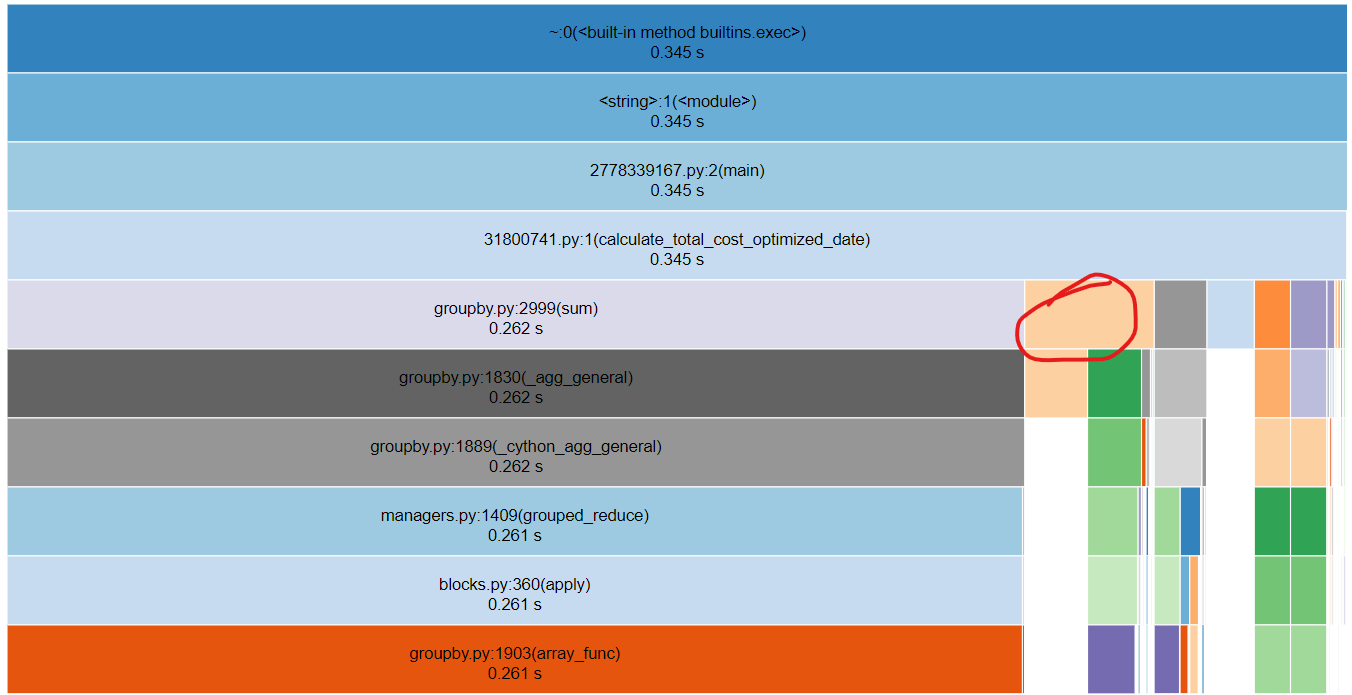

The selected area shows the time consumed by the add_period_start_date_optimized function. Now, it takes a fraction of the time it did before. The total processing time is now dominated by the summation over all the rows. This summation is highly optimized and I consider it unlikely that there are still worthwhile optimizations to be done in Python. 

If this solution is not fast enough, the next step would be to apply multiprocessing to speed things up even more.